<a href="https://colab.research.google.com/github/Xorbitt/LaneDetection/blob/main/lane_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install -Uqq fastbook
import fastbook

In [3]:
fastbook.setup_book()

Mounted at /content/gdrive


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import json
import numpy as np
import cv2
import matplotlib.pyplot as plt
from fastai.vision.all import *
from skimage import io
from google.colab.patches import cv2_imshow

In [4]:
p = Path('/content/drive/My Drive/laneDetection/vid/')
get_msk = lambda o: p/'labels'/f'{o.stem}{o.suffix}'

(720, 1280)


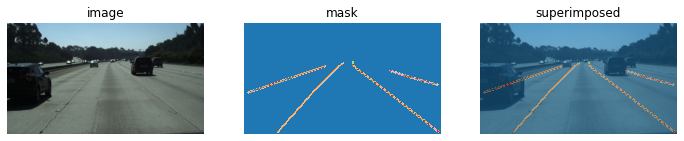

In [5]:
fnames = get_image_files(p/'clips/')
msk = PILMask.create(get_msk(fnames[0]))
fnames = fnames[:1000]
cam_img = PILImage.create(fnames[0])
resolution = cam_img.shape
print(resolution)
cam_img.shape, msk.shape
_,axs = plt.subplots(1,3, figsize=(12,3))
cam_img.show(ctx=axs[0], title='image')
msk.show(alpha=1, ctx=axs[1], vmin=0, vmax=5, title='mask')
cam_img.show(ctx=axs[2], title='superimposed')
msk.show(ctx=axs[2], vmin=0, vmax=5);

In [6]:
path = Path("/content/drive/My Drive/laneDetection/vid")
codes = ["background"]
for i in range(1, 10):
  codes.append(f"lane{i}")
codes

['background',
 'lane1',
 'lane2',
 'lane3',
 'lane4',
 'lane5',
 'lane6',
 'lane7',
 'lane8',
 'lane9']

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1142: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


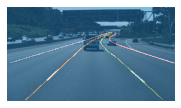

In [7]:
from pathlib import Path
os.chdir("/content/drive/My Drive/laneDetection/vid")
path = Path("/content/drive/My Drive/laneDetection/vid")
dls = SegmentationDataLoaders.from_label_func(path, bs=1, fnames = fnames,
                                              label_func = lambda o: path/"labels"/f"{o.stem}{o.suffix}",
                                              codes = np.loadtxt(path/"codes.txt", dtype=str))

                                      #   item_tfms=Resize(resolution[0] // 2, method=ResizeMethod.Squish),
                                          
dls.show_batch()



In [8]:
def acc(inp, targ):
  targ = targ.squeeze(1)
  mask = targ != 'background'
  return (inp.argmax(dim=1)[mask]==targ[mask]).float().mean()

In [9]:
opt = ranger
learn = unet_learner(dls, resnet18, self_attention=True, metrics=acc, act_cls=Mish, opt_func=opt)
learn.fine_tune(3)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1142: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


epoch,train_loss,valid_loss,acc,time
0,0.104315,0.083801,0.978152,19:23


epoch,train_loss,valid_loss,acc,time
0,0.074337,0.079391,0.978733,20:08
1,0.055002,0.062675,0.980385,19:46
2,0.045014,0.058163,0.981458,19:56


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1142: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


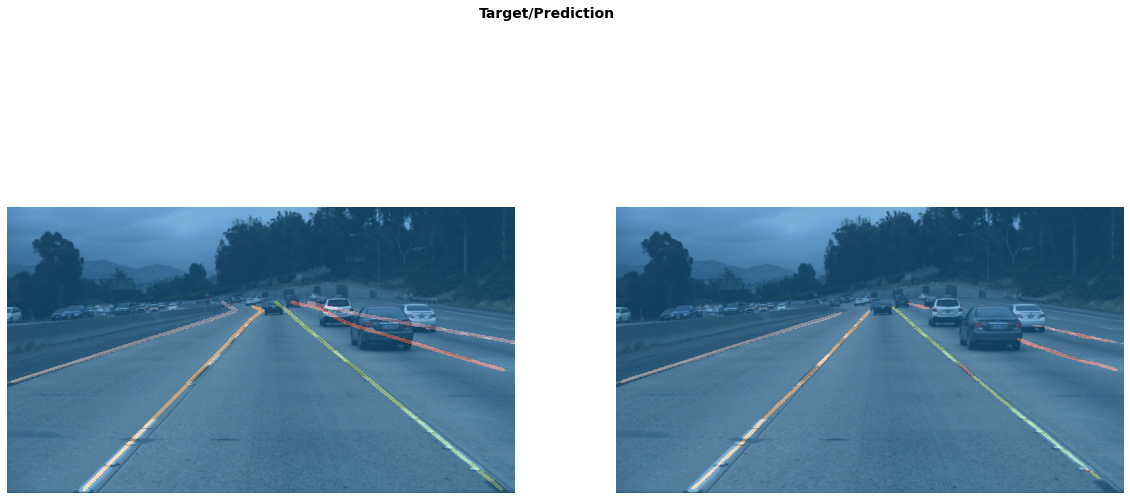

In [18]:
learn.show_results(max_n=4, figsize=(20,10))

In [ ]:
preds,y,losses = learn.get_preds(with_loss=True)
interp = SegmentationInterpretation(learn, preds, y, losses)